## 잡음 제거 오토인코더
- 잡음 제거 오토인코더 
- Paper 
    - (DAE)_Extracting and Composing Robust Features with Denosing Autoencoders 에서 처음제안
   

In [4]:
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

# 오토인코더 생성하는 이미지 관찰을 위한 matplotlib, numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# 하이퍼 파라미터
epochs = 3
batch_size = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [5]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root = 'data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

In [6]:
## 오토인코더 모듈 정의

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # self.encoder, self.decoder 정의 및 nn.sequential()을 이용한 묶기
        # encoder - FC-FC-FC
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), # 3개여의 특징만 남긴다. (입력의 특징을 3차원 압축)
        )
        
        # decoder - FC-FC-FC 채널 역순
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), # 3개여의 특징만 남긴다.
            nn.Sigmoid(), # 마지막 출력값을 0~1사이로 만들어주는 nn.Sigmoid() 함수가 더해진 것
        )
        
    # Forward
    def forward(self, x):
        encoded = self.encoder(x) # encoder 생성
        decoded = self.decoder(encoded) # encoder 바탕으로 decoder 

        return encoded, decoded # 복원 이미지

In [7]:
# noise 추가 함수
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

# 학습 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    
    avg_loss = 0
    
    # step 마다 train_loader 에서 데이터를 불러옴.
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x) # 입력에 노이즈 더하기
        x = x.view(-1, 28*28).to(DEVICE) # 입력값도 X 
        y = x.view(-1, 28*28).to(DEVICE) # 결과값도 X
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        # loss 계산, 미분 및 역전파, 반복
        loss = criterion(decoded, y)
        optimizer.zero_grad() # 오차에 대해 미분
        loss.backward() # 역전파 진행
        optimizer.step() # 
        
        # 평균 오찻값을 저장하는 avg_loss 변수
        avg_loss +=loss.item() # loss 의 텐서 뽑아서 저장
    return avg_loss / len(train_loader)

[Epoch 1] loss:0.07535816453444932
[Epoch 2] loss:0.06542326341957044
[Epoch 3] loss:0.06414496157564588


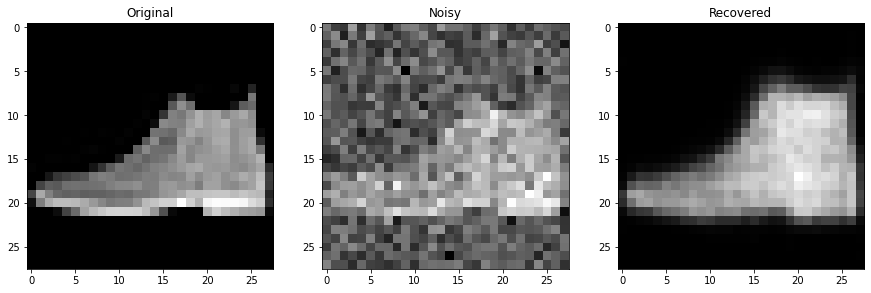

In [9]:
# 모델 옵션 설정 및 학습
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) # 최적화 모듈 Adam
criterion = nn.MSELoss() # 두 행렬간의 차이제곱

# 학습 진행
for epoch in range(1, epochs+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

# Fashion MNIST 데이터셋
testset = datasets.FashionMNIST(
    root = 'data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

# 이미지를 add_noise로 오염시킨 후 모델에 통과
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

# 원본과 디코딩 비교해보기 - subplot 에 출력
f, a = plt.subplots(1, 3, figsize = (15,15))

original_img = np.reshape(original_x.data.numpy(), (28,28))
noisy_img = np.reshape(noisy_x.data.numpy(), (28,28))
recovered_img = np.reshape(recovered_x.data.numpy(), (28,28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()